# Question 3: Backprop using Auto-differentiation
Purpose: To derive a version of my Network module that uses AD.

In [75]:
import numpy as np
from utils import *
from matad import *
from copy import deepcopy
import matplotlib.pyplot as plt

# Dataset

In [76]:
# DiscreteMapping dataset
n_classes = 3
in_dim = 2

np.random.seed(9201)
B = np.eye(n_classes)
A = 4.*np.random.rand(n_classes, in_dim)
ds = DiscreteMapping(A, B, n=300, noise=0.2)

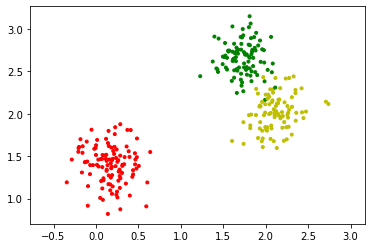

In [77]:
ds.plot()

# (a) `Mul` class and its wrapper `mul` (action required)

In [78]:
# The function "mul" is a wrapper for using the MatOperation class Mul.
def mul(a, b):
    '''
     v = mul(a, b)

     Matrix multiplication between two Mat objects.
     
     Inputs:
       a   Mat object, DxM
       b   Mat object, MxN
       
     Output:
       v   Mat object, DxN
       
     Note:
       v.creator points to the correspdoning Mul object
           of the MatOperation class
    '''
    return Mul([a, b])()

class Mul(MatOperation):
    def __init__(self, args):
        '''
         op = Mul(args)
         
         Creates a Mul object which implements matrix-matrix multiplication
         and its derivative.
         
         Inputs:
           args  list of two Mat objects
           
         Usage:
           a = Mat(...)
           b = Mat(...)
           op = Mul([a,b])  # creates the operation object
           v = op()         # evaluates the operation
        '''
        self.args = args

    def __call__(self):
        '''
         v = op() where op is a Mul object
         
         Evaluates the multiplication.
         The arguments (Mat objects) were specified at instatiation.
         
         Output:
           v   Mat containing the product
        '''
        c = Mat(self.args[0].val @ self.args[1].val)
        c.creator = self
        return c

    def backward(self, s=None):
        '''
         op.backward(s=None)
         
         Computes the 66 of the Mul operation with respect to its arguments,
         and applies that (using chain rule) to s, the input derivative.
         It then delivers the resulting derivatives to its arguments.
         
         Input:
           s  2D NumPy array (not a Mat object)
        '''
        # Appropriate backward propogation according to the result of Q2
        self.args[0].backward(s@self.args[1].val.T)  
        self.args[1].backward(self.args[0].val.T@s)  


# `Layer` class and `Population` class

In [79]:
# Abstract base class for layers
class Layer(object):
    def __init__(self):
        return

    def __call__(self, x=None):
        raise NotImplementedError

In [80]:
# Population layer represents a layer of nodes, and applies the
# activation function. It also stores the input current (z) and
# the node activations (h).
class Population(Layer):
    '''
     lyr = Population(act=logistic)

     Creates a layer of nodes, and applies the activation
     to its input currents.

     Inputs:
       act  activation function
            This function should take a Mat object as input
            and output a Mat object.
          
     Usage:
       lyr.z  # Mat object, stores node input currents
       lyr.h  # Mat object, stores node activities
       lyr()  # returns lyr.h
       lyr(x) # applies activation function to x (Mat object)
    '''
    def __init__(self, act=logistic):
        self.z = None  # Mat object
        self.h = None  # Mat object
        self.act = act
        self.params = []

    def __call__(self, x=None):
        if x is not None:
            self.h = self.act(x)
        return self.h

In [81]:
class DenseLayer(Layer):
    '''
     lyr = DenseLayer(from_nodes=1, to_nodes=1, act=logistic)

     The DenseLayer class puts the connection weights and
     activation function together into a single class.
     This compound layer is composed of:
       L1: a Connection object, followed by
       L2: a Population object.

     Inputs:
       from_nodes  number of nodes in sending layer
       to_nodes    number of nodes in receiving layer
       act         activation function
                   This function should take a Mat object as input
                   and output a Mat object.

     Usage:
       lyr.L1  # Connection layer object
       lyr.L2  # Population layer object
       h1 = lyr(h0) # returns activity of receiving layer, after
                    # passing h0 through L1 and then L2.
       h = lyr()  # returns the activities stored in lyr.L2
    '''
    def __init__(self, from_nodes=1, to_nodes=1, act=logistic):
        self.L1 = Connection(from_nodes=from_nodes, to_nodes=to_nodes)
        self.L2 = Population(act=act)
        self.params = self.L1.params

    def __call__(self, x=None):
        if x is None:
            return self.L2.h
        else:
            return self.L2(self.L1(x))

# (b) `Connection` class (action required)

In [82]:
# Connection class
class Connection(Layer):
    '''
     lyr = Connection(from_nodes=1, to_nodes=1)

     Creates a layer of all-to-all connections.

     Inputs:
       from_nodes  number of nodes in source layer
       to_nodes    number of nodes in receiving layer
      
     Usage:
       lyr.W   # holds the connection weights (Mat object)
       lyr.b   # holds the biases (Mat object)
       lyr.params  # a list of parameters, [W,b]
       z = lyr(h)  # projects activities h (Mat) through the
                   # connection to get input currents z (Mat)
                   # ie. z = h @ W
    '''
    def __init__(self, from_nodes=1, to_nodes=1):
        super().__init__()
        self.Nin = from_nodes    # number of nodes in input (lower) layer
        self.Nout = to_nodes     # number of nodes in higher layer

        self.W = Mat( np.random.randn(self.Nin, self.Nout) / np.sqrt(self.Nin) )
        self.b = Mat( np.zeros(self.Nout) )
        self.params = [self.W, self.b]

    def __call__(self, x):
        if x is None:
            print('Should not call Connection without arguments.')
            return

        #This is just x*W + b and return the Operation class instance. 
        return plus(mul(x,self.W),self.b)  


# (c) `Network` class (action required)

In [83]:
class Network(object):
    '''
     net = Network()

     Creates a Network object, which represents a series of
     layers, and a cost (loss) function.

     Usage:
       net.lyr  # returns a list of Layer objects
       net.add_layer(L)  # appends the Layer L to the network
       y = net(x)  # feeds inputs x through the network
                   # x is a 2D numpy array or a Mat object
                   # returns y (Mat object)
       net.loss    # loss function (MatOperation object)
    '''
    def __init__(self):
        self.lyr = []
        self.loss = None

    def add_layer(self, L):
        self.lyr.append(L)

    def __call__(self, x):
        if type(x) not in (Mat, ):
            x = Mat(x)
        for l in self.lyr:
            x = l(x)
        return x

    def parameters(self):
        '''
         params = net.parameters()
         
         Returns a list of Mat objects of the connection weights and
         biases in the network (from bottom to top).
         Note that only Connection layers have these parameters.
        '''
        params = []
        for l in self.lyr:
            if l.params:  # skips empty lists
                params.append(l.params[0])
                params.append(l.params[1])
        return params
    
    def learn(self, ds, lrate=1., epochs=10):
        '''
         net.learn(ds, lrate=1., epochs=10)

         Runs backprop on the network, training on the data from
         the Dataset object ds.

         Inputs:
           ds       a Dataset object
           lrate    learning rate
           epochs   number of epochs to run
        '''
        x = ds.inputs()
        t = ds.targets()
        for epoch in range(epochs):

            y = self(x)             # forward pass

            #===== YOUR CODE BELOW =====
            loss = self.loss(y,t) #calculate the loss so that we can do backprop
            loss.zero_grad() #reset all gradients
            loss.backward() #calculate gradients
            for i in self.parameters():
              i.set(i.val-lrate*i.grad) #Do gradient descent on each parameter
            # Report progress
            if epoch%50==0:
                print(f'{epoch}: cost = {loss()[0,0]}')

# Create a network

In [84]:
# Create a network object
# 2 input nodes -> 10 hidden nodes -> 3 output nodes
net = Network()
input_pop = Population(act=identity)
dl1 = DenseLayer(from_nodes=2, to_nodes=10, act=logistic)
dl2 = DenseLayer(from_nodes=10, to_nodes=3, act=logistic)
net.add_layer(input_pop)
net.add_layer(dl1)
net.add_layer(dl2)
# Loss function
net.loss = mean_ce
lrate = 1.

# Train and test the network
Your edited code should work on these lines

In [85]:
# you might have to run this a few times
net.learn(ds, lrate=lrate, epochs=500)

0: cost = 2.09402768668806
50: cost = 0.639390933928657
100: cost = 0.3109170203201348
150: cost = 0.1823889320089321
200: cost = 0.12295085425819832
250: cost = 0.08978201003180514
300: cost = 0.06903884265590426
350: cost = 0.055134841867414984
400: cost = 0.04534670318582819
450: cost = 0.038183634917594696


In [86]:
y = net.lyr[-1]().val
print(y[:6,:])

[[9.52543635e-01 1.46887750e-03 3.90415020e-02]
 [4.36637919e-05 9.99133665e-01 4.53550676e-03]
 [4.89202840e-03 6.85400279e-03 9.86365147e-01]
 [2.25353304e-02 2.69729085e-03 9.76602236e-01]
 [9.95232517e-01 1.02735145e-03 4.20767962e-03]
 [5.04890570e-05 9.97483641e-01 1.16332703e-02]]


In [87]:
ds.targets()[:6,:]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

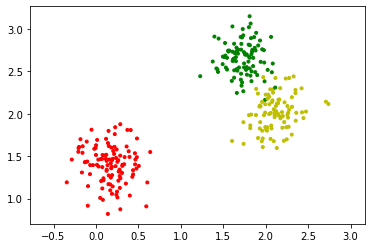

In [88]:
ds.plot(labels=y);

In [89]:
def accuracy(y, t):
    '''
     ac = accuracy(y, t)
     
     Calculates the fraction of correctly classified samples.
     A sample is classified correctly if the largest element
     in y corresponds to where the 1 is in the target.
     
     Inputs:
       y  a batch of outputs, with one sample per row
       t  the corresponding batch of targets
       
     Output:
       ac the fraction of correct classifications (0<=ac<=1)
    '''
    #===== YOUR CODE HERE =====
    # transfer y and t into a 1-dimentional array, where each element is the index of the original larger value
    # For example, [[0,1],[1,0]]->[0,1]
    yAry = np.argmax(y, axis=1)
    tAry = np.argmax(t, axis=1)
    
    # now create a true/false array which records where y,t has the same/different prediction
    accuracyAry = yAry==tAry
    
    # count the number of True's in the array, the number is how many we have predic
    corrects = np.count_nonzero(accuracyAry==True)
    
    # record the total number of samples as the total length of the array, i.e., sample size
    sampleSize = len(tAry)
    
    # return the correct rate by using the number of correct predictions divided by sample size.
    return corrects/sampleSize

In [90]:
accuracy(ds.targets(),y) # Output the accuracy

1.0

## You can also try your code on the `UClasses` dataset

Inputs are 2D
Targets are one-hot 2-vectors


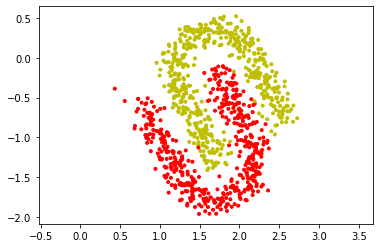

In [59]:
ds = UClasses(n=1000)
print(f'Inputs are {ds.input_dim}D')
print(f'Targets are one-hot {ds.n_classes}-vectors')
ds.plot();